## Malaria Detection Using Convolutional Neural Networks

In [1]:
#importing important libraries
import numpy as np
import pandas as pd
import h5py
import glob
import cv2
import matplotlib.pyplot as plt

In [2]:
#Create a list of image paths to import images.
parasitized_folder = glob.glob(r'C:\Users\USER\Documents\Complete ML\Datasets\cell_images\Parasitized\*.png')
uninfected_folder = glob.glob(r'C:\Users\USER\Documents\Complete ML\Datasets\cell_images\Uninfected\*png')
print("Length of parasitized_folder: %d"%len(parasitized_folder))
print("Length of uninfected_folder: %d"%len(uninfected_folder))

Length of parasitized_folder: 13779
Length of uninfected_folder: 13779


In [3]:
"""
The data is suffieciently large, hence, we will do all the splitting operations on path files 
before working with the actual image data.
"""
data_path = pd.DataFrame({
    'image_path': parasitized_folder + uninfected_folder,
    'label': ['Parasitized']*len(parasitized_folder) + ['Uninfected']*len(uninfected_folder)
}).sample(random_state=10).reset_index(drop=True)
data_path.head()

,image_path,label
0,C:\Users\USER\Documents\Complete ML\Datasets\c...,Parasitized
1,C:\Users\USER\Documents\Complete ML\Datasets\c...,Parasitized
2,C:\Users\USER\Documents\Complete ML\Datasets\c...,Uninfected
3,C:\Users\USER\Documents\Complete ML\Datasets\c...,Parasitized
4,C:\Users\USER\Documents\Complete ML\Datasets\c...,Uninfected


In [4]:
#Split path values before importing image data to save memory.
from sklearn.model_selection import train_test_split
train_X_path, test_X_path, train_Y_path, test_Y_path = train_test_split(
    data_path['image_path'].values, 
    data_path['label'].values, 
    test_size=0.2, random_state=10)

In [5]:
print("size of train_X_path: %d"%len(train_X_path))
print("size of test_X_path: %d"%len(test_X_path))
print("size of train_Y_path: %d"%len(train_Y_path))
print("size of test_Y_path: %d"%len(test_Y_path))

size of train_X_path: 22046
size of test_X_path: 5512
size of train_Y_path: 22046
size of test_Y_path: 5512


In [6]:
"""
The function takes an index and image path as parameters and returns a numpy array 
containing image data.
The size of cell images vary, so we are resizing the image to the average size of 
blood cell images i.e. (128, 128)
An intercubic interploation is used to sample 4x4 neighboring pixels to generate 
a good quality of resized image.
"""
def img_path_to_array(index, path):
    if index % 5000 == 0:
        print("Image conversion completed: " + str(index))
    img = cv2.imread(path)
    img = cv2.resize(img, dsize=(128,128),
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [7]:
#Enumerated image paths to keep track of processing during map
train_X_enum = [(index, path) for index, path in enumerate(train_X_path)]
test_X_enum = [(index, path) for index, path in enumerate(test_X_path)]

In [8]:
#processing the images by mapping enumerated path array into img_path_to_array function
print('Processing Train Images:')
train_X_map = map(img_path_to_array,
                        [index[0] for index in train_X_enum],
                        [path[1] for path in train_X_enum])
train_X = np.array(list(train_X_map))

print('\nProcessing Test Images:')
test_X_map = map(img_path_to_array,
                        [index[0] for index in test_X_enum],
                        [path[1] for path in test_X_enum])
test_X = np.array(list(test_X_map))

Processing Train Images:
Image conversion completed: 0
Image conversion completed: 5000
Image conversion completed: 10000
Image conversion completed: 15000
Image conversion completed: 20000

Processing Test Images:
Image conversion completed: 0
Image conversion completed: 5000


In [9]:
#Enumerated image labels to keep track of processing during map
train_Y_enum = [(index, label) for index, label in enumerate(train_Y_path)]
test_Y_enum = [(index, label) for index, label in enumerate(test_Y_path)]

In [10]:
"""
This function takes index and label path as parameters and returns the encoded 
value of the label i.e. '1' for parasitized & '0' for Uninfected.
"""
def label_path_to_array(index, label):
    if index % 5000 == 0:
        print("Label conversion completed: " + str(index))
    if label == 'Parasitized':
        return 1
    else:
        return 0

In [11]:
#processing the images by mapping enumerated path array into label_path_to_array function
print('Processing Train Label:')
train_Y_map = map(label_path_to_array,
                        [index[0] for index in train_Y_enum],
                        [label[1] for label in train_Y_enum])
train_Y = np.array(list(train_Y_map)).reshape(-1,1)

print('\nProcessing Test Label:')
test_Y_map = map(label_path_to_array,
                        [index[0] for index in test_Y_enum],
                        [label[1] for label in test_Y_enum])
test_Y = np.array(list(test_Y_map)).reshape(-1,1)

Processing Train Label:
Label conversion completed: 0
Label conversion completed: 5000
Label conversion completed: 10000
Label conversion completed: 15000
Label conversion completed: 20000

Processing Test Label:
Label conversion completed: 0
Label conversion completed: 5000


In [12]:
print("shape of train_X: " + str(train_X.shape))
print("shape of train_y: " + str(train_Y.shape))
print("shape of test_X: " + str(test_X.shape))
print("shape of test_X: " + str(test_Y.shape))

shape of train_X: (22046, 128, 128, 3)
shape of train_y: (22046, 1)
shape of test_X: (5512, 128, 128, 3)
shape of test_X: (5512, 1)


your sample is Parasitized


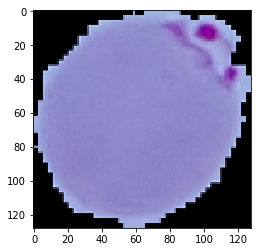

In [13]:
#a sample image and label for sanity check
index = 22000
if train_Y[index] == 1:
    diagnosis = 'Parasitized'
else:
    diagnosis = 'Uninfected'
print("your sample is " + diagnosis)
plt.imshow(train_X[index]/255.)

In [14]:
#Scaling the training data from 0-255 to 0-1 scale for better processing.
train_X_scaled = train_X/255.
test_X_scaled = test_X/255.

In [15]:
#importing tensorflow
import tensorflow as tf

In [16]:
"""
This function takes input shape of the convolutional neural network and drop rate for
regularization of the model to avoid overfitting and returns a model.
note: some of the layers are commented out for reducing the length and hence the 
training time of the model for trial purpose.
"""
def create_model(input_shape, drop_rate):
    """
    input:
    input_shape: it is the shape of input image, its (128,128) in this case.
    drop_rate: it is the drop rate for regularization.
    
    return:
    model: tensorflow model
    """
    
    #input layer shape
    inp_layer = tf.keras.layers.Input(shape = input_shape)
    #layer 1
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(inp_layer)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
    #layer 2
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
    """
    #layer 3
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(pool2)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)
    #layer 4
    conv4 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(pool3)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv4)
    #layer 5
    conv5 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding='same')(pool4)
    pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv5)
    """
    #flatten
    flat = tf.keras.layers.Flatten()(pool2)
    
    #hidden layer 1
    hid1 = tf.keras.layers.Dense(512, activation='relu')(flat)
    drop1 = tf.keras.layers.Dropout(rate=drop_rate)(hid1)
    #hidden layer 2
    hid2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
    drop2 = tf.keras.layers.Dropout(rate=drop_rate)(hid2)
    """
    #hidden layer 3
    hid3 = tf.keras.layers.Dense(256, activation='relu')(drop2)
    drop3 = tf.keras.layers.Dropout(rate=drop_rate)(hid3)
    #hidden layer 3
    hid4 = tf.keras.layers.Dense(128, activation='relu')(drop3)
    drop4 = tf.keras.layers.Dropout(rate=drop_rate)(hid4)
    """
    #output layer
    out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)
    #create final model
    model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)
    
    return model    

In [20]:
#create a model with create_model function and compile it to get the summary.
model = create_model((128, 128, 3), drop_rate=0.1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               33554944  
__________

In [19]:
#training the model
result = model.fit(x = train_X_scaled, y = train_Y, batch_size=64, epochs = 5, validation_data=(test_X_scaled, test_Y))

Train on 22046 samples, validate on 5512 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
22046/22046 [==============================] - 1270s 58ms/sample - loss: 0.4799 - acc: 0.7683 - val_loss: 0.2237 - val_acc: 0.9345
Epoch 2/5
22046/22046 [==============================] - 1168s 53ms/sample - loss: 0.1880 - acc: 0.9386 - val_loss: 0.1702 - val_acc: 0.9445
Epoch 3/5
22046/22046 [==============================] - 1137s 52ms/sample - loss: 0.1312 - acc: 0.9556 - val_loss: 0.1647 - val_acc: 0.9512
Epoch 4/5
22046/22046 [==============================] - 1127s 51ms/sample - loss: 0.0875 - acc: 0.9699 - val_loss: 0.1910 - val_acc: 0.9461
Epoch 5/5
22046/22046 [==============================] - 1120s 51ms/sample - loss: 0.0708 - acc: 0.9756 - val_loss: 0.2063 - val_acc: 0.9425
